# Prerequisites
You have at least a moderate understanding of Python, more specifically Python-3.

You know how to install Python modules (eg the `pip` tool), and how to set up a Python virtual environment (`virtualenv` module). If you need help on this,  try eg [here](https://djangocentral.com/how-to-a-create-virtual-environment-for-python/). 

## Installation

### TerminusDB server
Install the TerminusDB server as described [here](https://github.com/terminusdb/terminusdb-quickstart).

### Python client libraries and tutorials
Install the core Python Client, `WOQLQuery` and `woqlDataframe` support,  as described [here](https://github.com/terminusdb/terminus-client-python).

### Some standard libraries (if you do not already have them)
Install the Pandas Dataframe library,  as described [here](https://pandas.pydata.org/).  Note that this will also install the [NumPy](https://numpy.org/) scientific computing package. 

## Check your installation
Check that the following `import` list does not generate any Python errors:


In [60]:
import pandas as pd
import woqlclient.woqlClient as woql
from woqlclient import WOQLQuery
import woqlclient.errors as woqlError
import woqlclient.woqlDataframe as wdf

---

## Run the TerminusDB server
Run TerminusDB as described [here](https://github.com/terminusdb/terminusdb-quickstart)

You can verify that TerminusDB is running by opening the TerminusDB console at `http://localhost:6363/console` in your browser.  You should then see 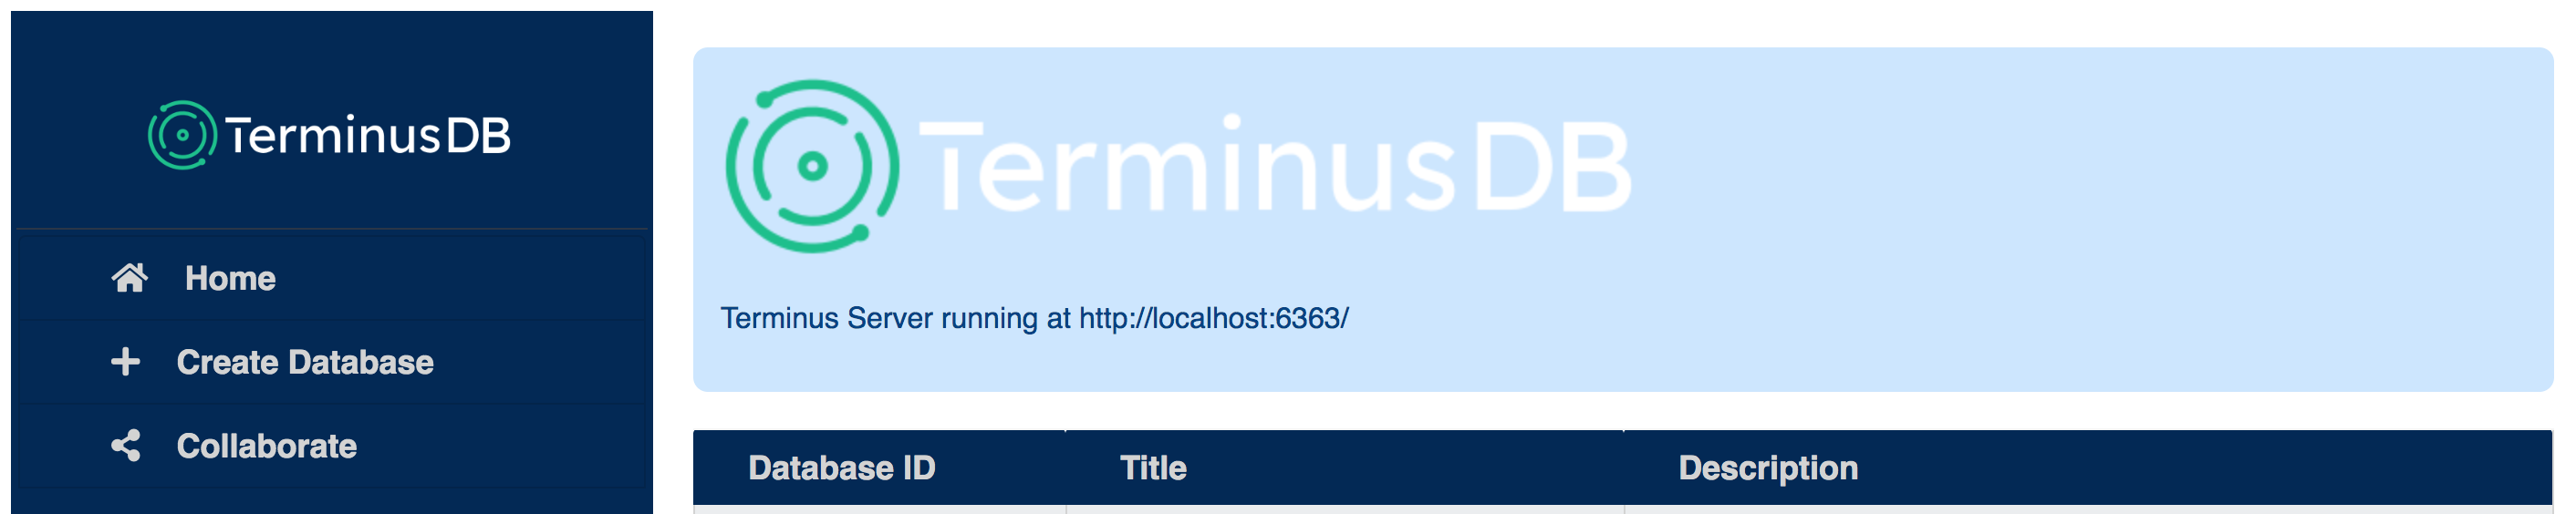 

followed by a list of databases which you have previously created - or none at all,  if this is your very first time..

---

# First steps - creating a database

## TerminusDB databases
You can create your own TerminusDB databases, under the TerminusdB server running locally on your machine.  

With the Terminus Hub which the core team are about to release, you will also be able to share, collaborate and use community databases for and with fellow Terminators worldwide.

Each of your own databases,  which you have previously created, are listed by name in TerminusDB console (in the window in your browser).

----

## Connecting to your TerminusDB server
Connecting to the TerminusDB server is straight-forward. However -- and don't be put off! -- it will generate a *lot* of diagnostic output from TerminusDB.

For that reason,  I've put a ';' after the last line in this code cell below, so as to ask the Jupyter notebook to suppress all the output that would otherwise be generated...

In [61]:
server_url                      = "http://localhost:6363"
key                             = "root"

client = woql.WOQLClient()
print("[Connecting to the TerminusDB server..]")
client.connect(server_url, key);     # Use a ';' here to suppress the output in Jupyter...

[Connecting to the TerminusDB server..]
Sending to URL____________ http://localhost:6363/
sendRequestByAction_____________ connect


If you were to take the ';' out, then you would see something like the following:

```[Connecting to the TerminusDB server..]
Sending to URL____________ http://localhost:6363/
sendRequestByAction_____________ connect
{'@context': {'doc': 'http://localhost:6363/terminus/document/',
  'owl': 'http://www.w3.org/2002/07/owl#',
  'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
  'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
  'scm': 'http://localhost:6363/terminus/schema#',
  'tbs': 'http://terminusdb.com/schema/tbs#',
  ...etc...etc..etc...etc``` 
  
Currently the Python `woqlclient` module does not have a nice switch to turn all this stuff off (the core team told me they would add it..).

So to make things more palatable in the interim,  here's a useful little wrapper function that I use to put aside all the diagnostic output clutter:

In [62]:
import sys
import os

class suppress_Terminus_diagnostics:
    '''
        Suppress information messages from the TerminusDB libraries.

        At some point,  the woqlclient library will probably have an explicit setting to do this.

        In the meantime,  cf https://stackoverflow.com/questions/8391411
    '''

    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

And,  so now you can do:

In [63]:
with suppress_Terminus_diagnostics():
    client.connect(server_url, key)

This has connected you to the TerminusDB server,  and all those diagnostics messages are now being silently suppressed.

If the `woqlclient` detects an error, or the TerminusDB server returns an error, an exception is raised (typically, of the exception class `woqlError.APIError`).  You may thus also wish to wrap calls to TerminusDB in a `try..except..` clause -- but to keep the tutorial here as straight-forward as possible, I generally have not included exception handling.

----

## Making your first database
To create your very first database,  try:

In [64]:
with suppress_Terminus_diagnostics():
    client.createDatabase("DB_1", "My first database")       

If you now check the TerminusDB console in your browser,  you should see: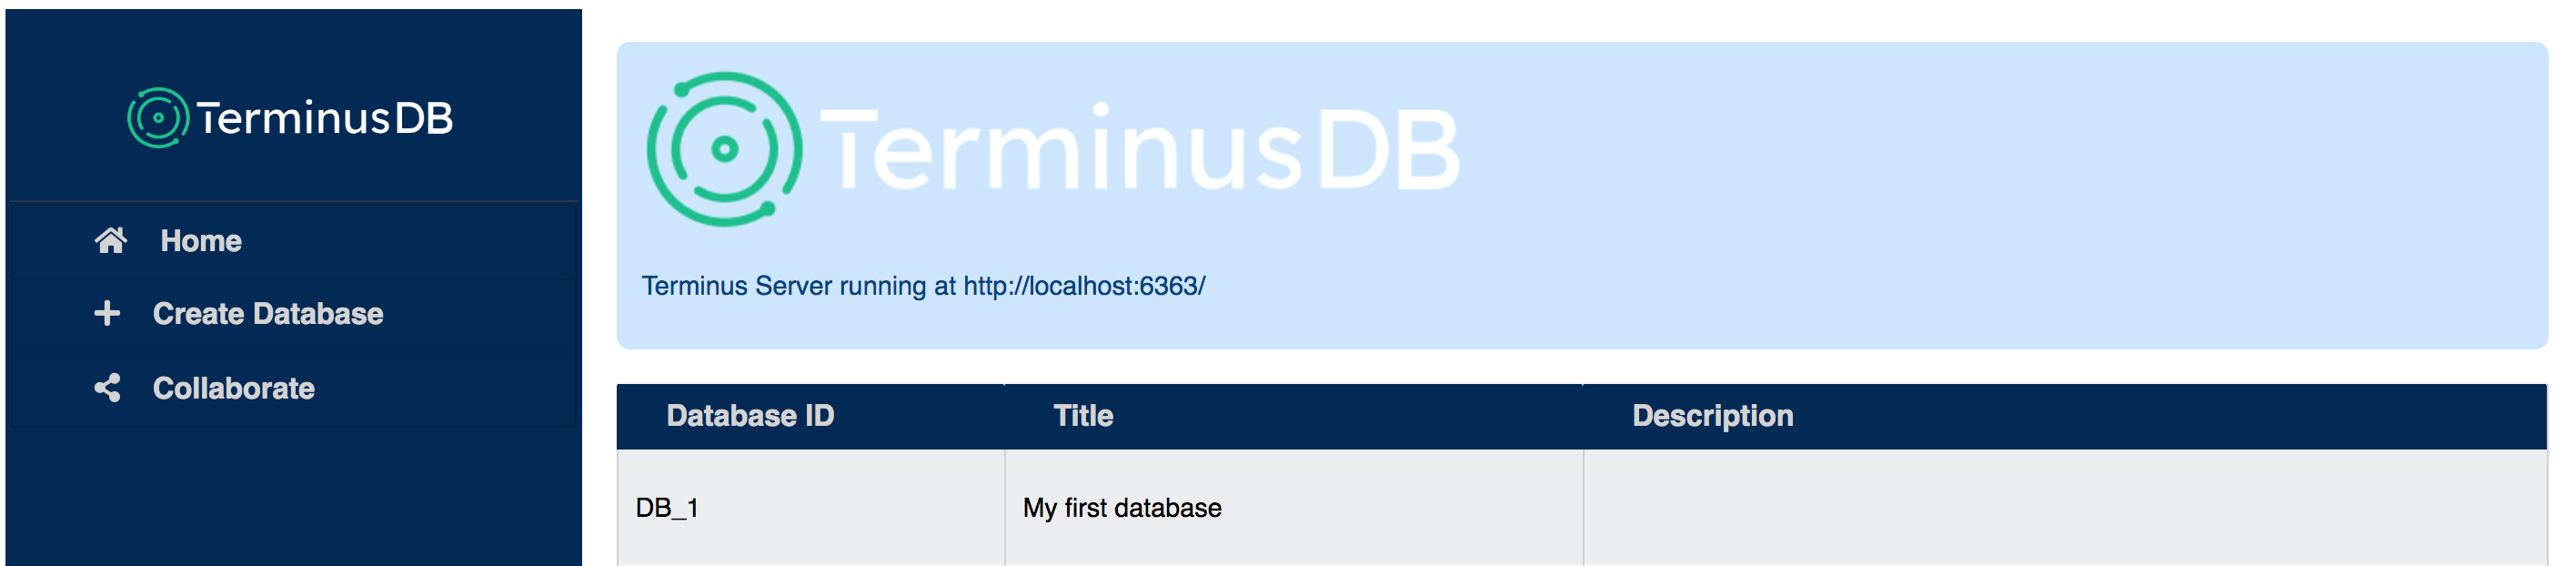

And if you click into your `DB_1` database,  you should see the following: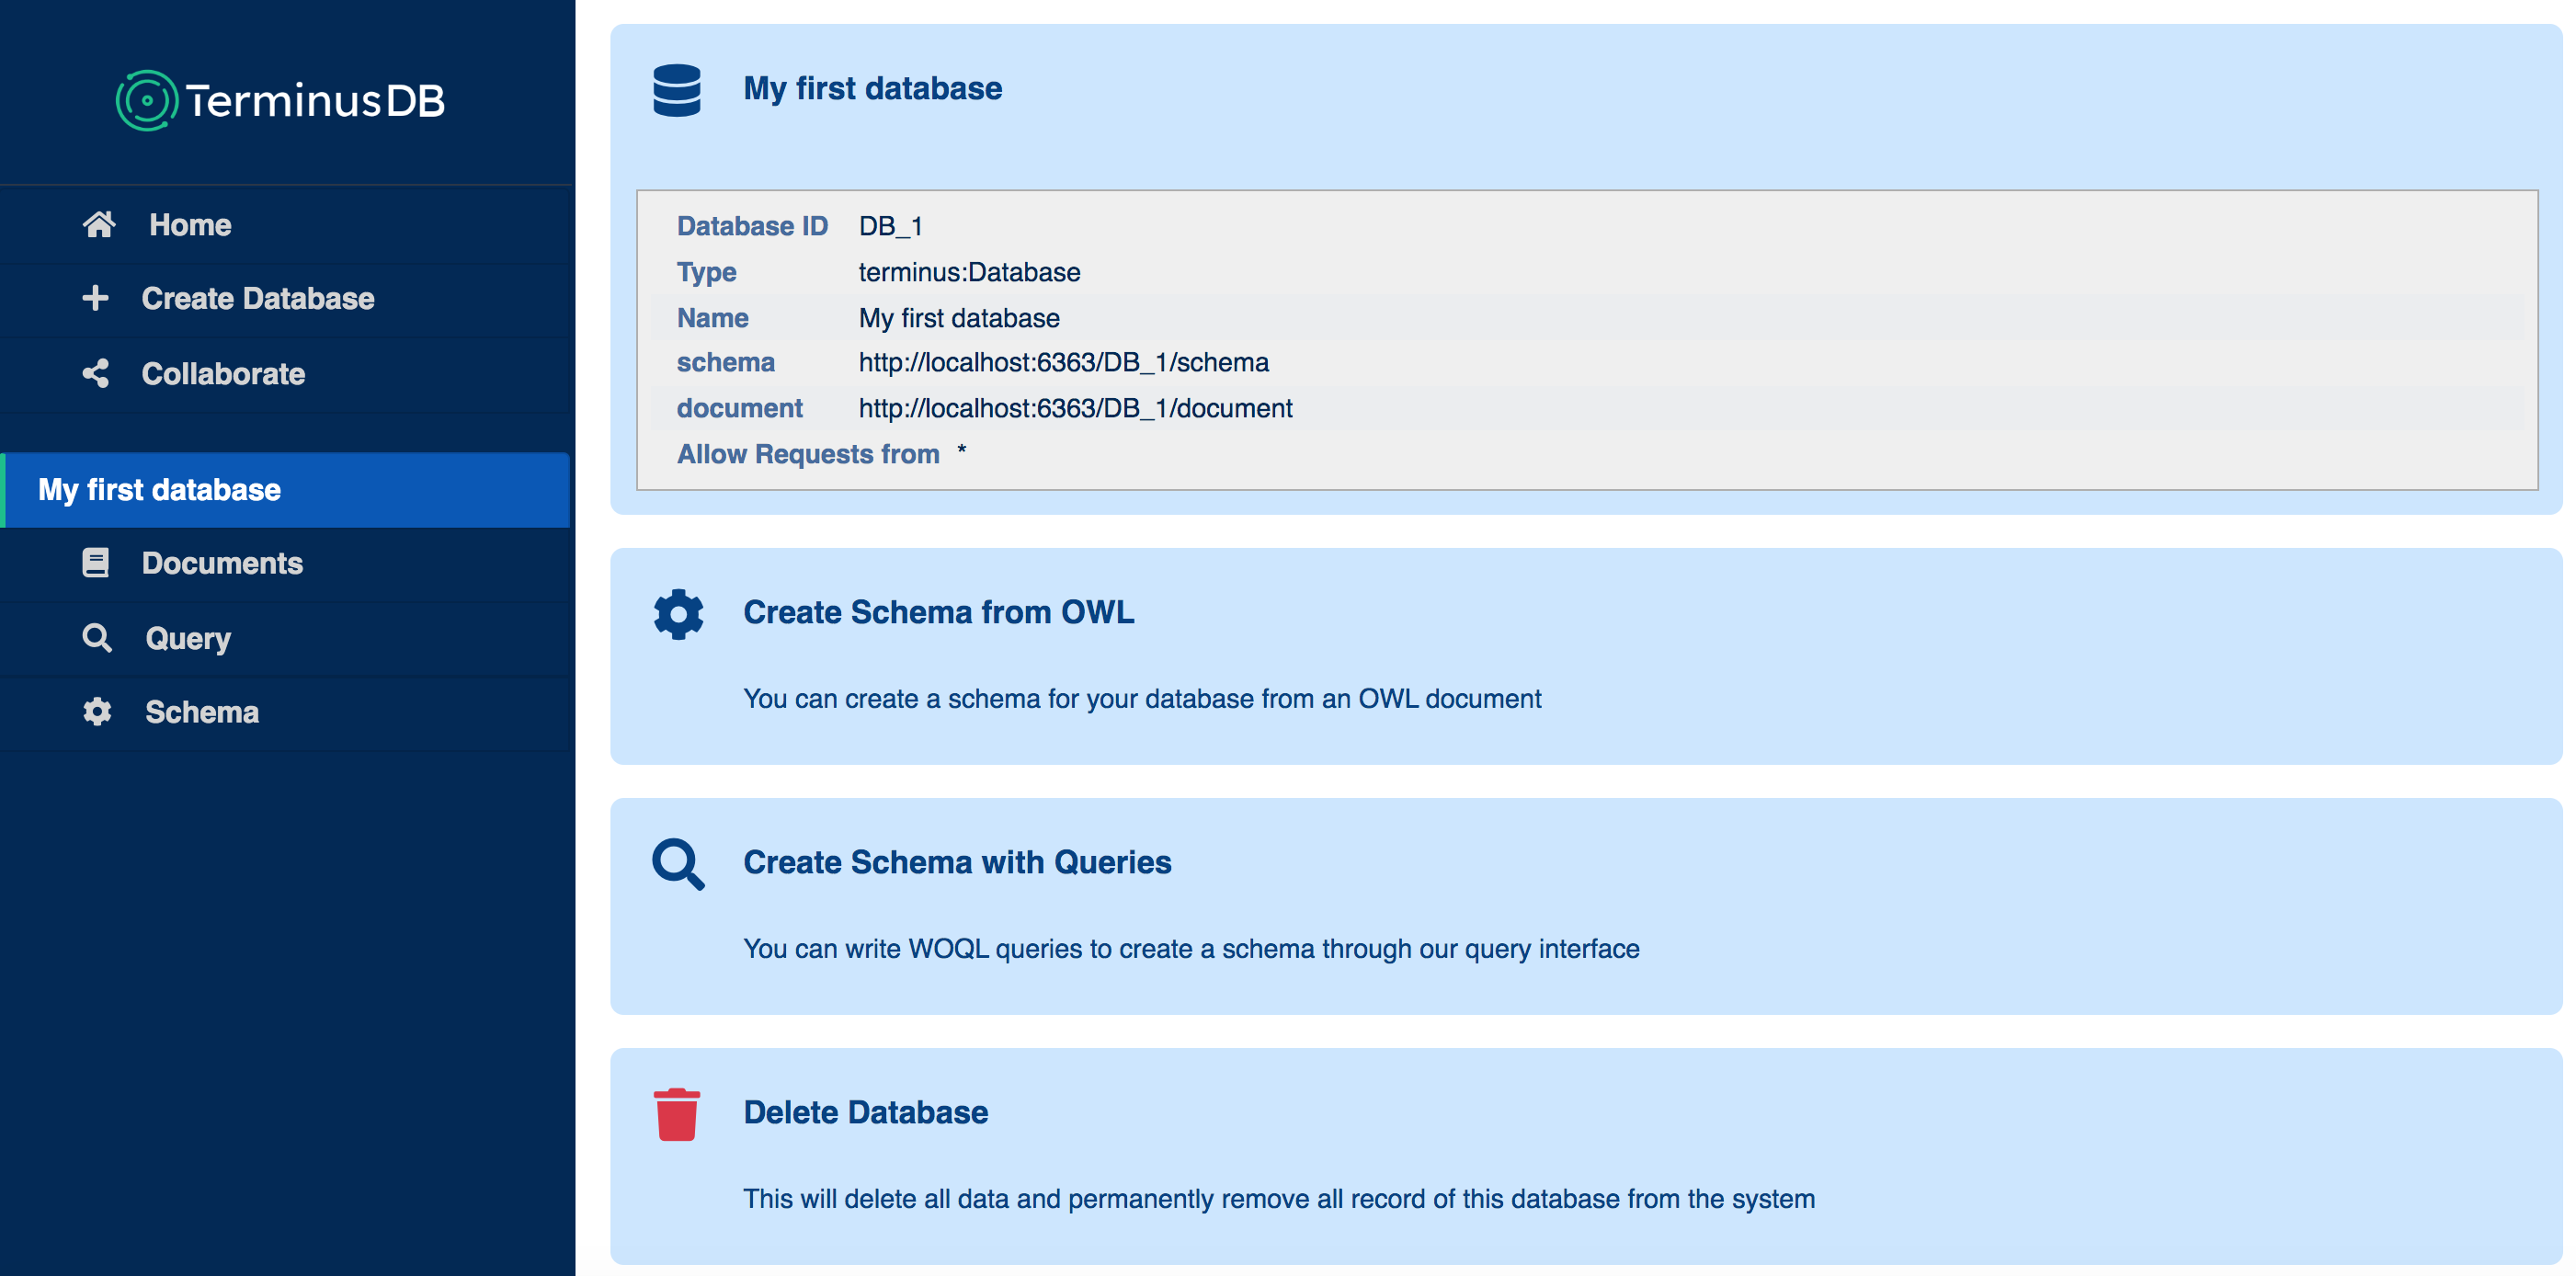

As the console suggests,  you can do things manually like creating a schema,  or deleting the database.  But we're going to do things programmatically using Python!

By the way,  if you try and run that code above again and so re-create the database a second time,  you will get a TerminusDB API exception with the message `"terminus:message":"Database already exists"`

----

## Deleting your database (and then recreating it..)
It might seem strange to want to delete your database immediately after creating it.  But usually when you are learning WOQL and experimenting,  you want your code to create a new database so that you have a clean start each time you try something new.  And,  if so if your database previously exists, perhaps you may want to delete the old one before creating the new one. So,  for the purposes of this tutorial, you probably want to do:

In [65]:
dBId = "DB_1"
try:
    print("[Removing prior version of database '{}',  if it exists..]".format(dBId))
    with suppress_Terminus_diagnostics():
        client.deleteDatabase(dBId)
except Exception as e:
    print("[No prior database to delete]")
    
print("[Creating database '{}']".format(dBId))
with suppress_Terminus_diagnostics():
    client.createDatabase(dBId, "My first database")

[Removing prior version of database 'DB_1',  if it exists..]
[Creating database 'DB_1']


----

# WOQL
In Python, every TerminusDB query is an instance of the `WOQLQuery` class. As is normal in Python, you can create an instance:

In [66]:
myQuery = WOQLQuery()

As you might expect,  there are many things you can do with a query.  The full list of methods available are listed [here](https://terminus-client-python.readthedocs.io/en/latest/woqlpy.html).

One of the core themes of WOQL is a "triple". Every triple relates some subject via some predicate to some object: eg "Jill's father is John", "Jill's age is 23",  "Jill's hobby is sailing" etc.

In WOQL,  this is expressed as `triple(subject, predicate, object)`. The `WOQLQuery` class has a `triple` method.

WOQL in Python makes extensive use of chaining.  Each call to a WOQL method returns a WOQL instance,  thus enabling you to build together a chain of calls of any length, of the form:  `WOQLQuery().triple(a,b,c).triple(d,e,f).triple(g,h,i).`

Once a query is formed, you then have to submit it for execution to the TerminusDB server. Let's read on..

---

# Creating a schema
*Every* TerminusDB database has a schema.  The schema describes the nature and structure of the data within the database.

The basic unit of a TerminusDB schema is a `document`.  Each document has an associated type (it's `doctype`). You can think of a TerminusDB document as akin to a Python object,  and its associated type as akin to a Python class.

A doctype can be introduced `doctype(<Some Type Name>).description(<A short summary>)`. 

To create a doctype,  naturally you use a WOQL query: `WOQLQuery().doctype(<Some Type Name>).description(<A short summary>)`.

Finally,  to update the database -- which you need to do,  if you are creating a schema.. -- the WOQL query `when` method is used.  The `when` has an associated condition: when the condition is true,  then run the associated query and update the database.  If you are a database guru, you've probably guessed that `when` thus must acquire a write-lock for the update; and you are correct!

Putting this all together, we can do:

In [67]:
schema = WOQLQuery().when(
                True,
                WOQLQuery().doctype("PersonType").description("Somebody")
        )

At this point, a query has been created. We now need to *execute* the query.  We could continue to wrap our calls to the TerminusDB server with the `suppress_Terminus_diagnostics` clause, but to show you that these calls happening, I'm going to leave out that `with` clause from now on..

In [68]:
print("[Building schema..]")
schema.execute(client)

[Building schema..]
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update


{'bindings': [{}], 'graphs': {}}

The result from executing the schema is a set of empty bindings and graphs:  essentially a null result,  indicating that the work has been done and there was nothing in particular to return for this particular query.

If you now check back again to your TerminusDB console, and click through the `DB_1` database and then look at the schema,  you should see the following: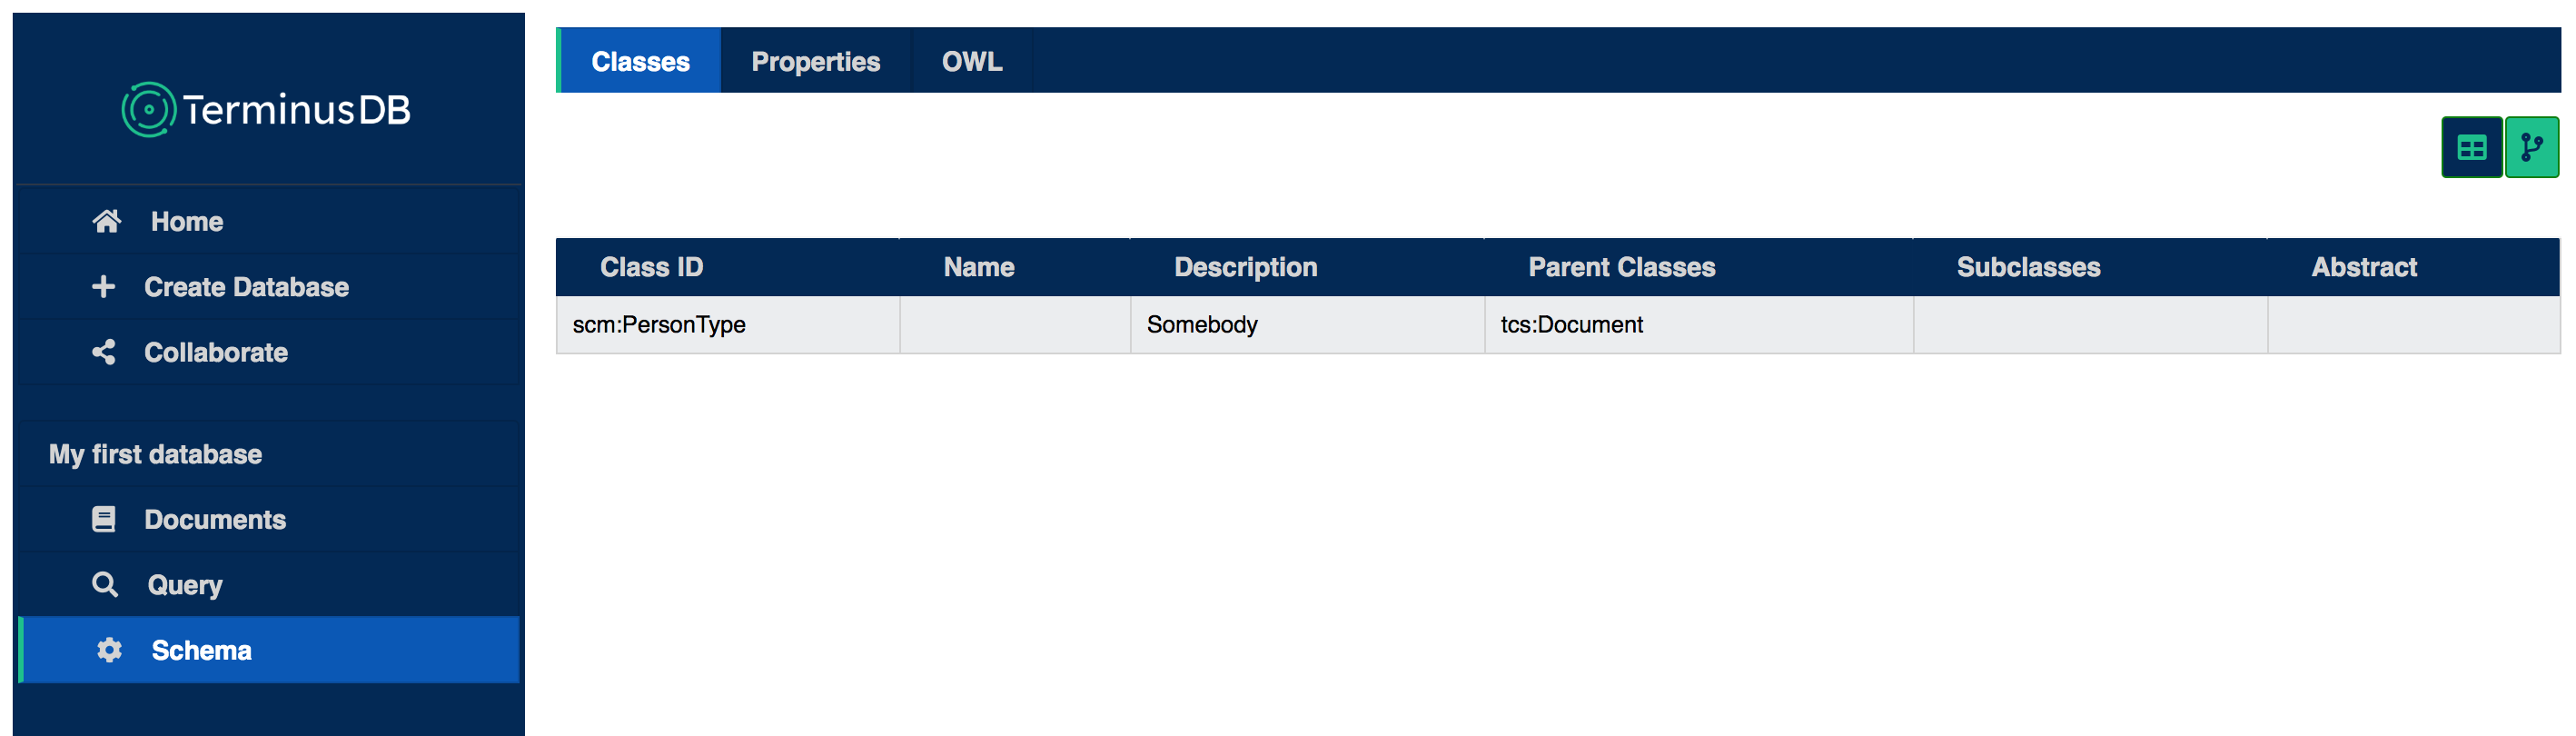 Oh, just a reminder,  you may need to refresh your browser window (since our database has changed), to see the change...

Note how the `Class ID` field in the console (in the dark blue line) is showing `PersonType`, from the `doctype` we have in our code.  Similarly,  the `Description` field is showing the `Somebody` value.

---

## Labels
WOQL optionally uses labels,  which then appear in the console, to help annotate.  We can revise our code to introduce one as a part of the `doctype` -- but beforehand we need to delete our database,  and recreate it:

In [69]:
dBId = "DB_1"
try:
    print("[Removing prior version of database '{}',  if it exists..]".format(dBId))
    with suppress_Terminus_diagnostics():
        client.deleteDatabase(dBId)
except Exception as e:
    print("[No prior database to delete]")
    
print("[Creating database '{}']".format(dBId))
with suppress_Terminus_diagnostics():
    client.createDatabase(dBId, "My first database")
    
schema = WOQLQuery().when(
                True,
                WOQLQuery().doctype("PersonType").description("Somebody").label("Person") # NB: label
        )                
print("[Building schema..]")
schema.execute(client)

[Removing prior version of database 'DB_1',  if it exists..]
[Creating database 'DB_1']
[Building schema..]
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update


{'bindings': [{}], 'graphs': {}}


And now if you look at the console, there is an entry under the `Name` field,  corresponding to the label we gave the doctype in the code above: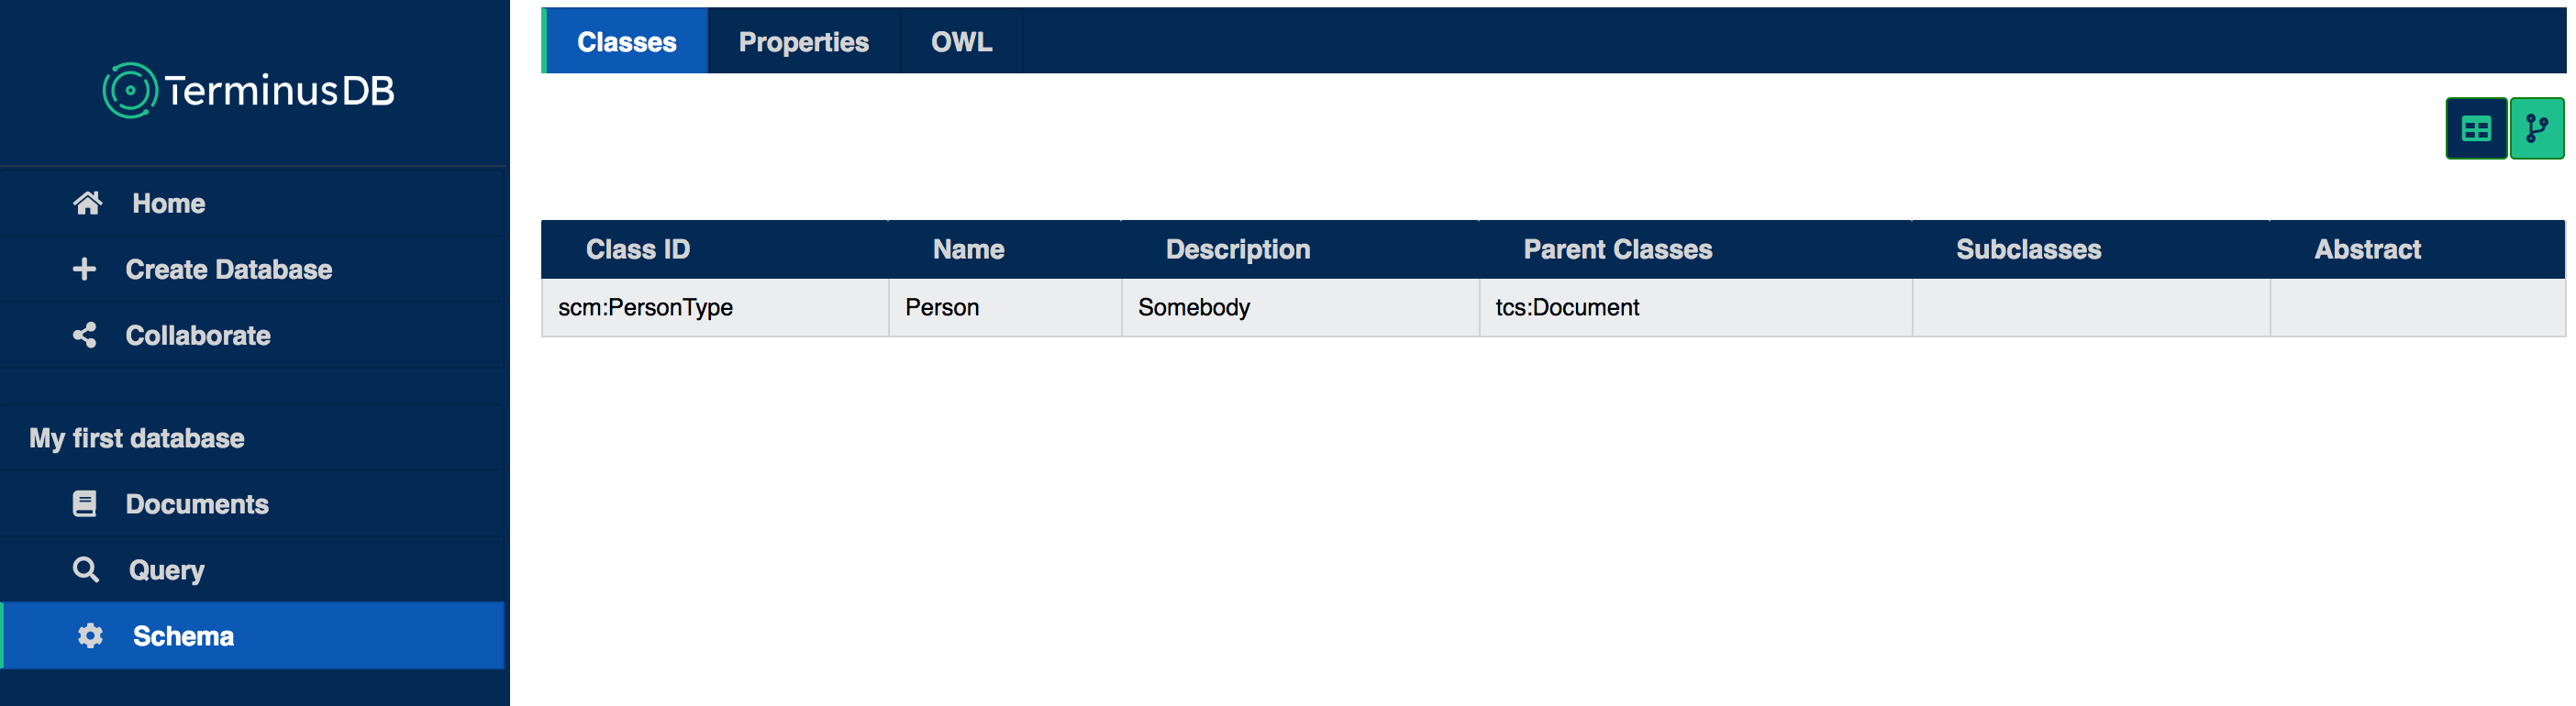.

Both the `description` and `label` attributes are meant as annotations,  with the description usually longer than the label.  In general, neither are used in code to manipulate data, but rather in the console to help display data.

---

## Adding a property
We can add basic properties to our simple `doctype` such as the `Name` and `Age` of each individual person (and again, recreating the database,  since we are experimenting and no longer need our orginal one..):

In [70]:
dBId = "DB_1"
try:
    print("[Removing prior version of database '{}',  if it exists..]".format(dBId))
    with suppress_Terminus_diagnostics():
        client.deleteDatabase(dBId)
except Exception as e:
    print("[No prior database to delete]")
    
print("[Creating database '{}']".format(dBId))
with suppress_Terminus_diagnostics():
    client.createDatabase(dBId, "My first database")
    
schema = WOQLQuery().when(
                True,
                WOQLQuery().doctype("PersonType").label("Person").description("Somebody").
                property("Name", "string").
                property("Age", "integer")
        )                
print("[Building schema..]")
schema.execute(client)               

[Removing prior version of database 'DB_1',  if it exists..]
[Creating database 'DB_1']
[Building schema..]
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update


{'bindings': [{}], 'graphs': {}}

If you now check back again to your TerminusDB console, click on your `DB_1` database, then the `Schema` button and then the `Properties` tab,  you should see: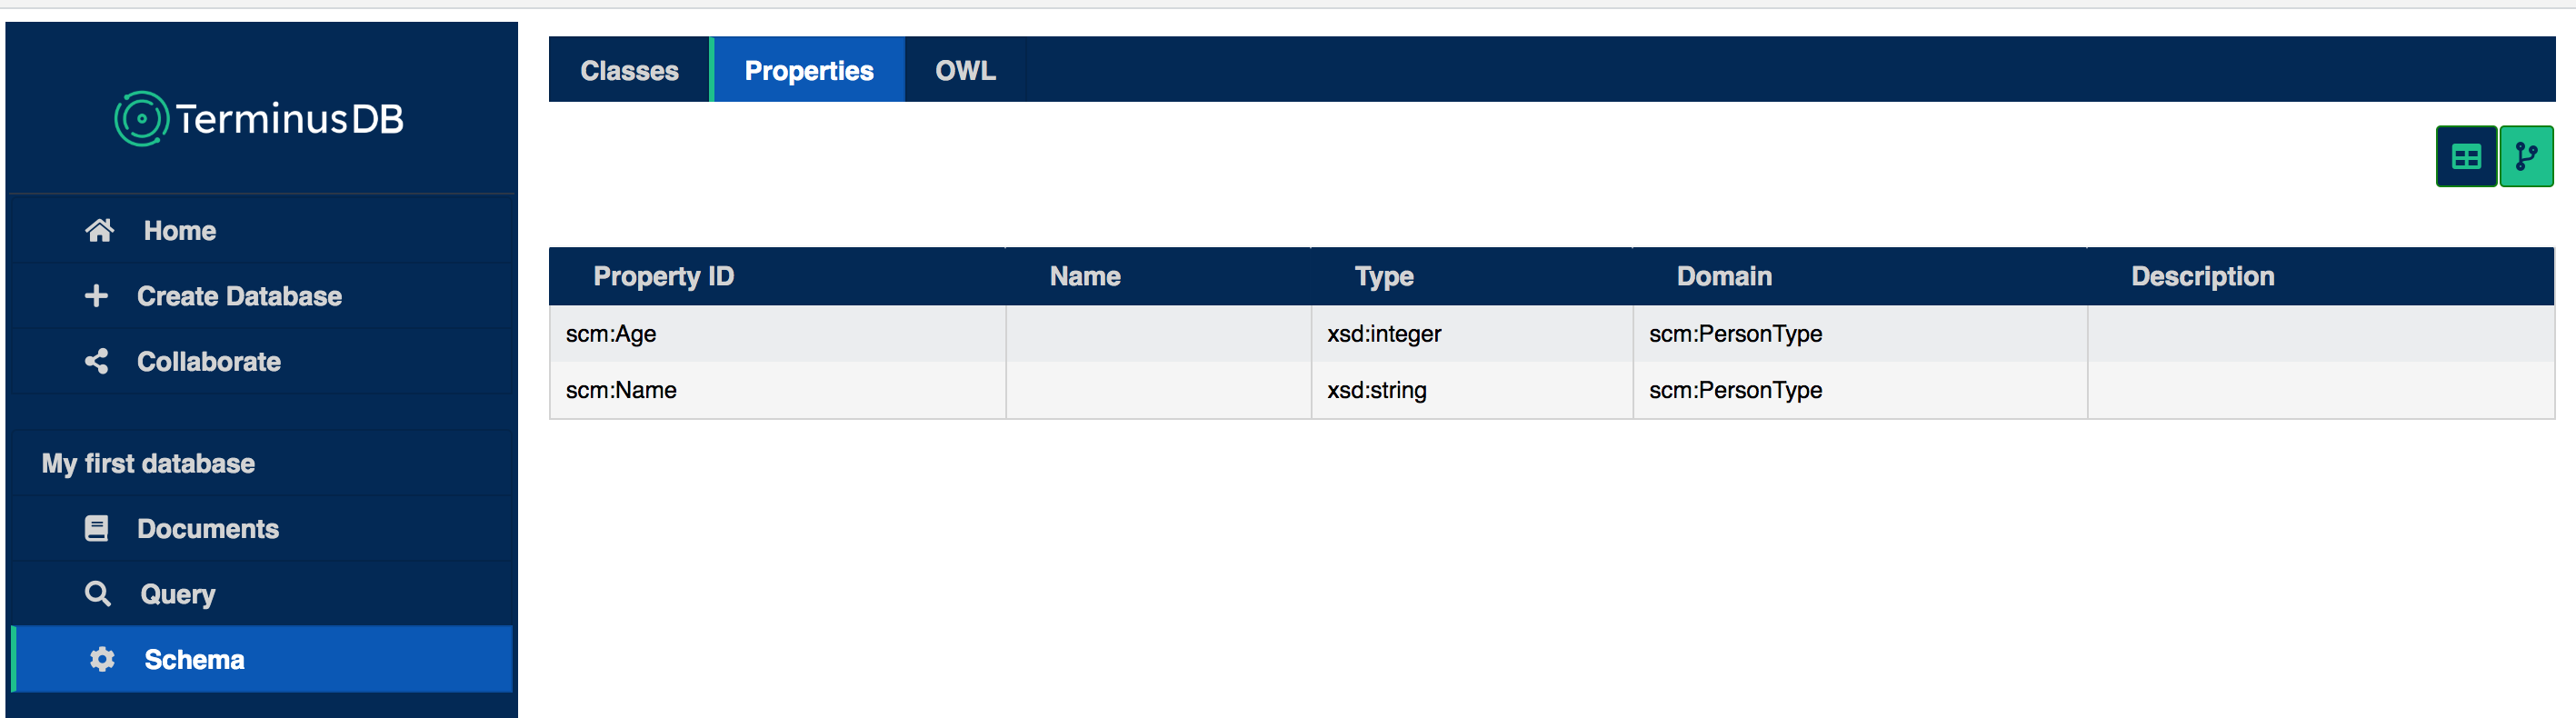:

We can also add labels and descriptions to the properties:

In [71]:
dBId = "DB_1"
try:
    print("[Removing prior version of database '{}',  if it exists..]".format(dBId))
    with suppress_Terminus_diagnostics():
        client.deleteDatabase(dBId)
except Exception as e:
    print("[No prior database to delete]")
    
print("[Creating database '{}']".format(dBId))
with suppress_Terminus_diagnostics():
    client.createDatabase(dBId, "My first database")
    
schema = WOQLQuery().when(
                True,
                WOQLQuery().doctype("PersonType").label("Person").description("Somebody").
                property("Name", "string").label("first_name").description("Given Name").
                property("Age", "integer").label("age").description("How old they are")
        )                
print("[Building schema..]")
schema.execute(client) 

[Removing prior version of database 'DB_1',  if it exists..]
[Creating database 'DB_1']
[Building schema..]
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update


{'bindings': [{}], 'graphs': {}}

The console now shows these labels and descriptions in the `Properties` field of the schema: 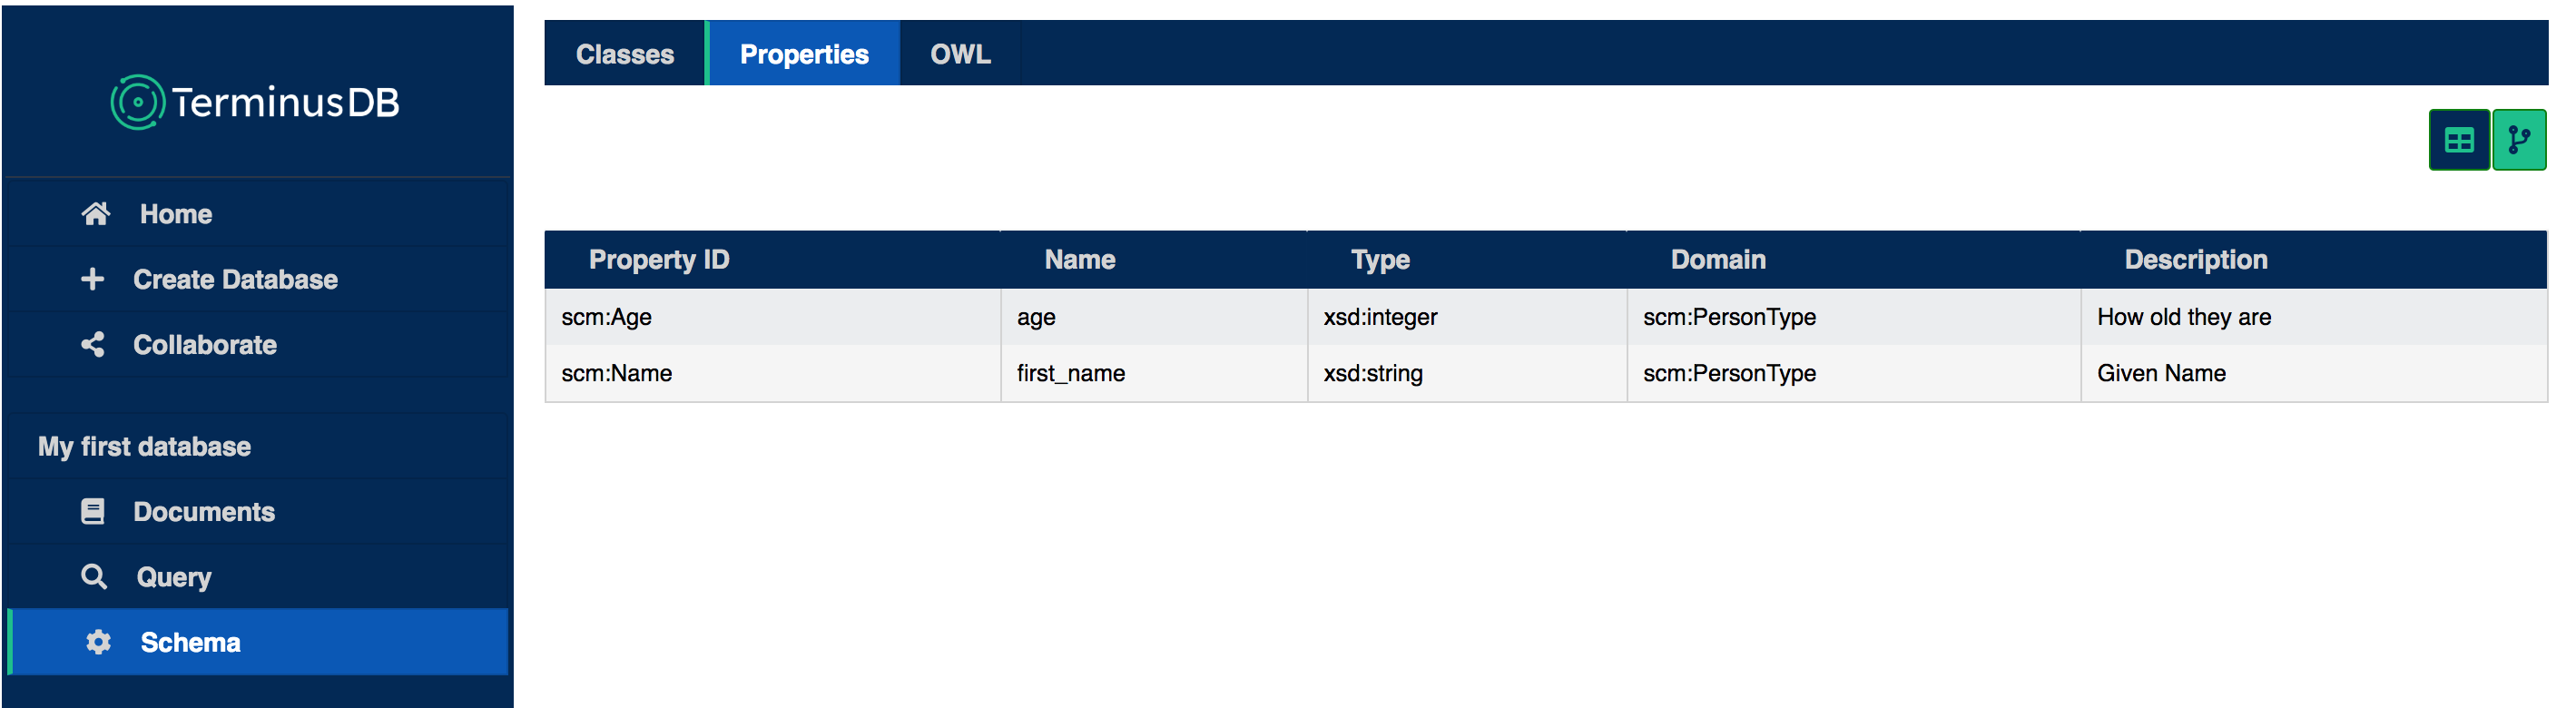

---
# Putting data into the database
There are two classic ways to put data into a TerminusDB.  You either code it directly;  or read raw data from an external `.csv` file, manipulate the raw data if necessary and finally insert it into the database.  WOQL has some explicit support for handling `.csv` files,  but let's defer this second approach and using `.csv` filea until later.

Lets focus on the first method instead.  Let's build some data in memory (rather than an external file), by defining a Python class and then a group of instances:

In [72]:
class Person:
    def __init__(self, age):
        self.age = age
        
Group = {
    'Joe': Person(17),
    'Siobhan': Person(18),
    'Seamus': Person(45),
    'Mary': Person(46),
    'Pat': Person(71),
    'Cliona': Person(74)
}

To place the `Group` into our `DB_1` database,  we're going to iterate over each member of the `Group`.  As we do so, we're also going to keep count (`Joe` will be `0`, `Siobhan` `1`, etc). This is classic Python, and can be done with a Python `zip`.  I'll use `nr` to keep track of the count number.

For each such `Person`, we need to set up a WOQL `when` clause to do the update. The condition for the `when` is going to be the creation of a new `PersonType` document,  and we will number the document with the current value of our count.

The WOQL `idgen` method does the work for us: it takes a document type, a list of values from which to fabricate a key, and returns a WOQL variable bound to the newly created document.  

What is a WOQL variable? Well, by convention, it is a string name with a `v:` prefix -- such as `v:Person_ID`.  So, each time we create a new document, we can use `v:Person_ID` to refer to that document.

By the way, the string name we use for the WOQL variable can be anything we want (such as `Person_ID`) and TerminusDB does not check that the name matches descriptions we have given in our schema.  So,  we could use `v:Foo` or `v:Bar` as far as it is concerned, but obviously the names you choose are good documentation hints to others reading your code.

The `idgen` thus looks like: `WOQLQuery().idgen("doc:PersonType", [nr], "v:Person_ID")` where `nr` is the current count value.

We then, in the second part of the `when` clause, need to insert the new document into our database. To do that, we'll use the WOQL `insert` method. It takes a WOQL variable representing the document to insert, and the type of that document.  For us, we will be inserting our `v:Person_ID` binding to our new document, and the type is `PersonType`.

If there is a `label` for the `doctype`,  then we need to fill it in. This is easy: it can be any unique string, so let's just use our loop counter `nr` as the basis for that.

Finally, we need to supply the `Name` and `Age` properties, using the WOQL `property` method. It takes the property name (eg `Age`) and the value we want to give it (eg the person's age) -- something like `property("Age", person.age)`.  

*HOWEVER:* there's a current gotcha bug in the `woqlclient` module. It gets upset if you try to pass a Python variable directly (WOQL variable bindings are fine, its just that Python variable values are not).  And so, you have to be a bit pedantic:  rather than just `person.age`,  you have to pass a Python dict `{'@type': 'xsd:integer', '@value': person.age}`.  Awkward, yes I know, and hope the core team will fix this soon.

And so, at last,  here is the loop to insert our data:

In [73]:
for (name, person), nr in zip(Group.items(), range(len(Group))):
    answer = WOQLQuery().when(
            WOQLQuery().idgen("doc:PersonType", [nr, 2*nr, 3*nr], "v:Person_ID"),
            WOQLQuery().insert("v:Person_ID", "PersonType").label("Nr:{}".format(nr)).
                property("Name", {'@type': 'xsd:string', '@value': name}).
                property("Age", {'@type': 'xsd:integer', '@value': person.age})
    )
    print("Inserting {}..".format(name))
    answer.execute(client)

Inserting Joe..
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
Inserting Siobhan..
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
Inserting Seamus..
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
Inserting Mary..
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
Inserting Pat..
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
Inserting Cliona..
Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update


(Of course, we can get rid of those TerminusDB diagnostics if you find them annoying, by simply putting in a `with suppress_TerminalDB_diagnostics()` wrapper again). 

And, looking into our console,  and the `Documents` button: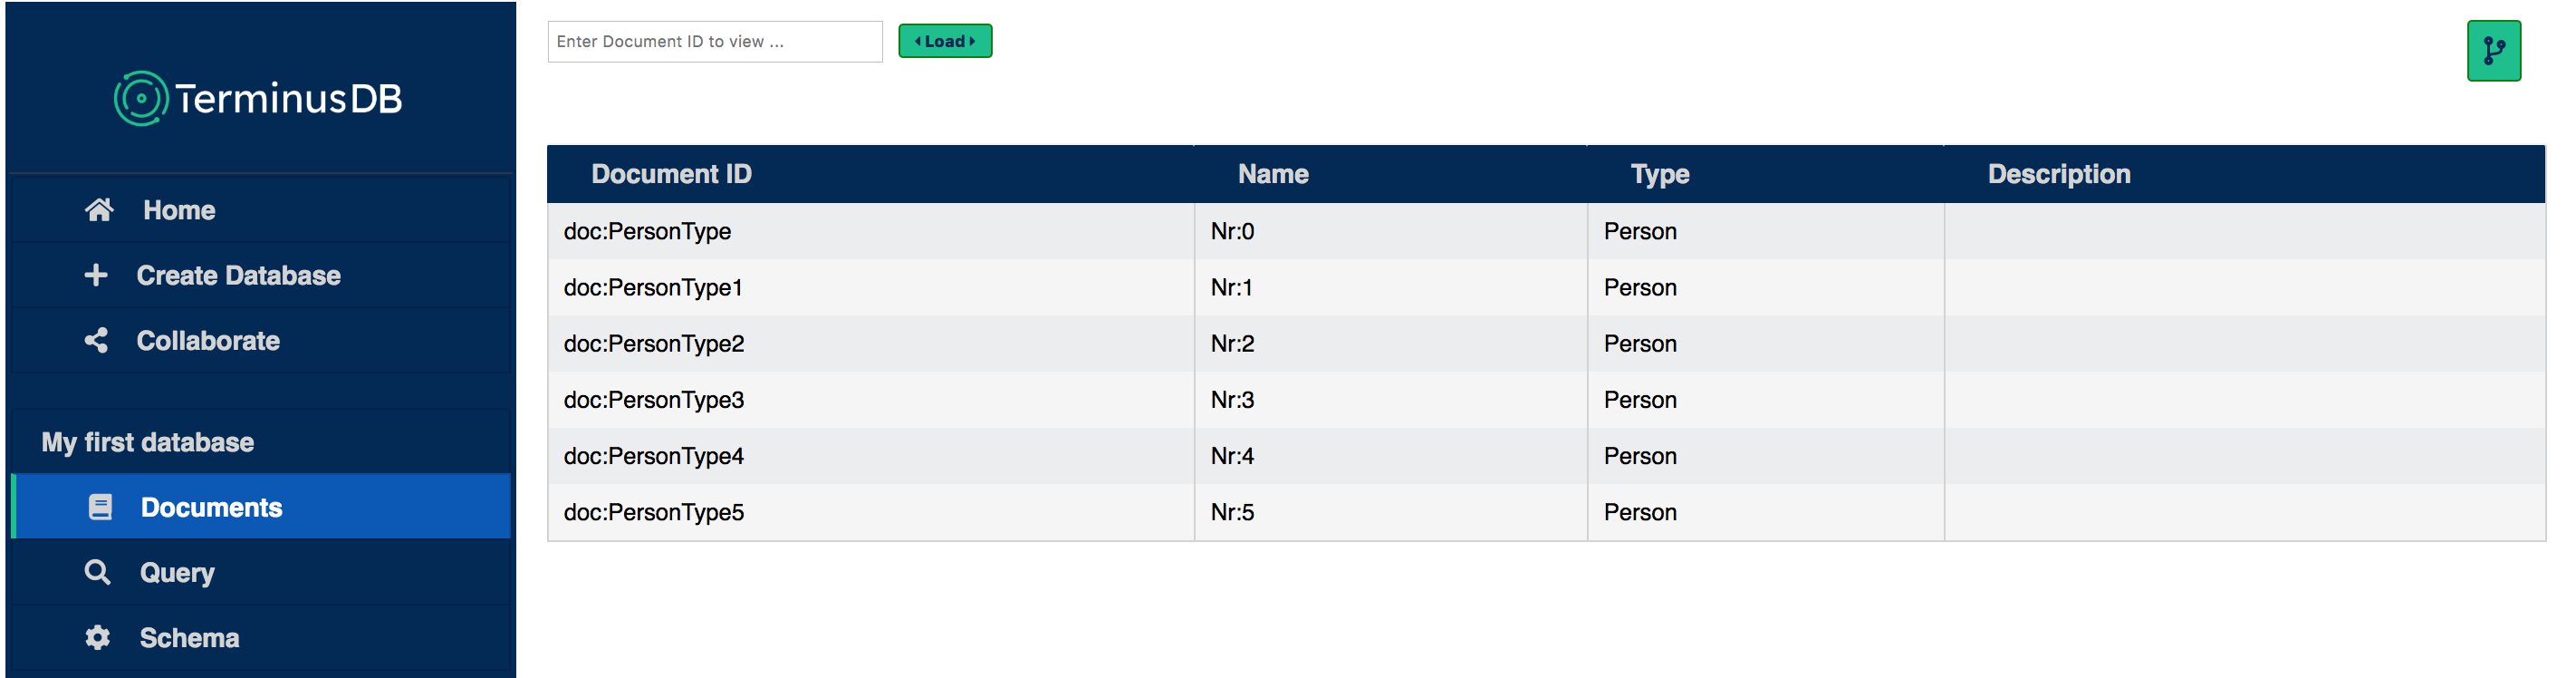

Clicking into any of the specific documents, eg number 3, will show you: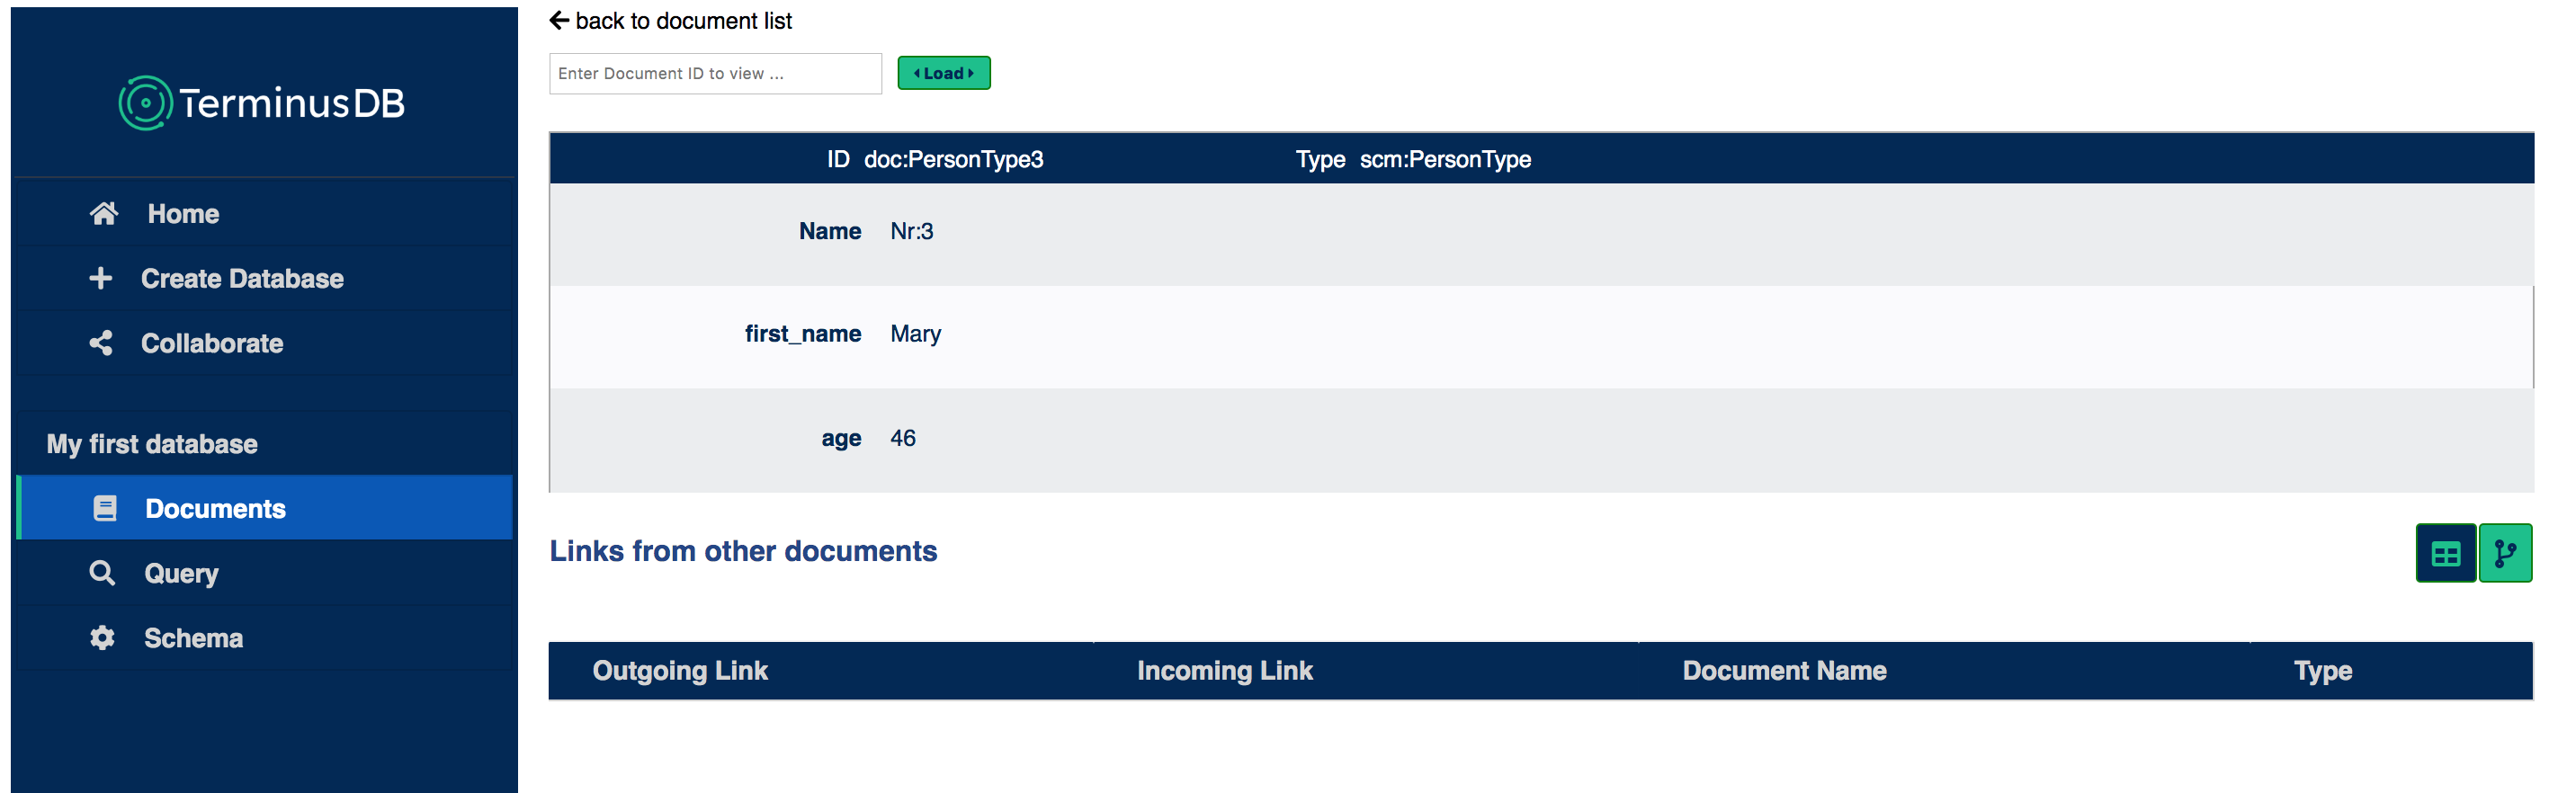

You remember I said that the `idgen` takes a Python list as its second parameter?  And we used just a singleton list with `nr`?  If you give more than a single value in the list, then the `idgen` concatenates the values together as the key. For example if you use `idgen("doc:PersonType", [nr, 2*nr, 3*nr], "v:Person_ID")` then our documents would have keys `PersonType123, PersonType246, PersonType369` etc...

---
# Making Queries
In fact, we've already been making queries! To do anything in TerminusDB, you make a query :-).

But you know what I mean. How do you do a *real* query and see what's in your database?

Well, its pretty straight-forward. Each query is a WOQL triple.  For example, to find all the people in our database,  and their name, we need to give a triple using the `Name` property,  and a WOQL variable binding to each resulting document, and another to each resulting person's name.  And execute it!

In [74]:
q = WOQLQuery().triple("v:Person", "Name", "v:Name")
result = q.execute(client)

Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update


OK...but what's in the `result`?  Let's try printing it:

In [75]:
print(result)

{'bindings': [{'http://terminusdb.com/woql/variable/Name': {'@type': 'http://www.w3.org/2001/XMLSchema#string', '@value': 'Joe'}, 'http://terminusdb.com/woql/variable/Person': 'http://localhost:6363/DB_1/document/PersonType'}, {'http://terminusdb.com/woql/variable/Name': {'@type': 'http://www.w3.org/2001/XMLSchema#string', '@value': 'Siobhan'}, 'http://terminusdb.com/woql/variable/Person': 'http://localhost:6363/DB_1/document/PersonType123'}, {'http://terminusdb.com/woql/variable/Name': {'@type': 'http://www.w3.org/2001/XMLSchema#string', '@value': 'Seamus'}, 'http://terminusdb.com/woql/variable/Person': 'http://localhost:6363/DB_1/document/PersonType246'}, {'http://terminusdb.com/woql/variable/Name': {'@type': 'http://www.w3.org/2001/XMLSchema#string', '@value': 'Mary'}, 'http://terminusdb.com/woql/variable/Person': 'http://localhost:6363/DB_1/document/PersonType369'}, {'http://terminusdb.com/woql/variable/Name': {'@type': 'http://www.w3.org/2001/XMLSchema#string', '@value': 'Pat'}, '

Wow.  Umm..A dict with lots of `bindings` and an empty `graphs` at the end. The `bindings` are a list of dicts. Err..each dict seems to have a set of `http://terminusdb.com/woql/variable/` keys, with our given WOQL variable name attached;  and then the dict value appears to be yet another embedded dict with a `@type` and `@value` keys,  and with the `@value` values giving the actual results we were expecting.

Yes. Exactly. Well. You *could* write your own code to wade through this and pick up the results. If you were brave enough.

But fortunately there is a better way. The woqlDataframe library (which we installed and then imported right at the start of this tutorial) has a neat function to convert a WOQL result into a pandas DataFrame.  Let's use it:

In [76]:
df = wdf.query_to_df(result)
print(df)

      Name                                             Person
0      Joe     http://localhost:6363/DB_1/document/PersonType
1  Siobhan  http://localhost:6363/DB_1/document/PersonType123
2   Seamus  http://localhost:6363/DB_1/document/PersonType246
3     Mary  http://localhost:6363/DB_1/document/PersonType369
4      Pat  http://localhost:6363/DB_1/document/PersonType...
5   Cliona  http://localhost:6363/DB_1/document/PersonType...


That's a *lot* better!

Maybe it would be nice to have the peoples' names and ages. And also to suppress those URLs referring to the actual `PersonType` documents in the database.  To do so, we can use a WOQL `select`.  And since now we want two sets of triples, for both the `Name` and `Age` properties, we need to join them together using a `woql_and`.  And one last thing, lets stop pandas from printing out its index numbers (the numbers on the left hand of the `print` above).  And so:

In [77]:
q = WOQLQuery().select("v:Name", "v:Age").woql_and(
        WOQLQuery().triple("v:Person", "Name", "v:Name"),
        WOQLQuery().triple("v:Person", "Age", "v:Age")
)
result = q.execute(client)
df = wdf.query_to_df(result)
print(df.to_string(index=False))

Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
 Age     Name
  17      Joe
  18  Siobhan
  45   Seamus
  46     Mary
  71      Pat
  74   Cliona


Cool.  If we want the WOQL `label` document field too (which we created with our WOQL `insert`), we can do that as follows:

In [78]:
q = WOQLQuery().select("v:Name", "v:Age", "v:label").woql_and(
        WOQLQuery().triple("v:Person", "Name", "v:Name"),
        WOQLQuery().triple("v:Person", "Age", "v:Age"),
        WOQLQuery().triple("v:Person", "label", "v:label")
)
result = q.execute(client)
df = wdf.query_to_df(result)
print(df.to_string(index=False))

Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
 Age     Name label
  17      Joe  Nr:0
  18  Siobhan  Nr:1
  45   Seamus  Nr:2
  46     Mary  Nr:3
  71      Pat  Nr:4
  74   Cliona  Nr:5


---
## Handlng empty results
What if the answer to our query is nothing,  that nothing at all matches?

I suspect you've already guessed that you'll get back a null result, with no bindings nor graphs (as we saw earlier when we created our schema).  And you'ld be correct!

However, if you go ahead and try and convert the result into a pandas DataFrame using `query_to_df`, you will get an exception thrown back to you (rather than perhaps a more gentler response of handing you back an empty DataFrame).

And so, you could pretest for a null result:

In [79]:
q = WOQLQuery().triple("v:Person", "Height", "v:height")
result = q.execute(client)
if len(result['bindings']) != 0:
    df = wdf.query_to_df(result)
else:
    print("Empty result!")

Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
Empty result!


Note that the WOQL query itself does not complain that it cannot find any people with a `Height` attribute: instead, it simply returns an empty result.  The `query_to_df` call however will raise an exception if you do call it: 

In [80]:
q = WOQLQuery().triple("v:Person", "Height", "v:height")
result = q.execute(client)
try:
    df = wdf.query_to_df(result)
except:
    print("Exception: Empty result!")

Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
Exception: Empty result!


---
# Deleting data
We've seen how to delete our entire database (and then re-create it).

But how do you select particular documents?  Let's say we want to find all people over 50 in our database,  and then remove them.

Finding our targets is easy.  There's a WOQL method `greater` to help us:

In [81]:
q = WOQLQuery().select("v:Name", "v:Age").woql_and(
        WOQLQuery().triple("v:Person", "Name", "v:Name"),
        WOQLQuery().triple("v:Person", "Age", "v:Age"),
        WOQLQuery().greater("v:Age", 50)
)
result = q.execute(client)
df = wdf.query_to_df(result)
print(df.to_string(index=False))

Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update
 Age    Name
  71     Pat
  74  Cliona


As I hope you might expect, we're going to use a WOQL `when` since we're going to update the database.  The condition we want is basically as above: a query to return all people over the age of 50.

The action we want the `when` then to do is to delete the associated documents.  Although we did not `select` them in the query above and then put them into our DataFrame, the documents are represented in our query above by the `v:Person` bindings.

To delete them,  we use the WOQL `delete_triple` method. This takes a variable binding (for us, `v:Person`), a property for the associated type, and the actual type itself (for us, this will be `"scm:PersonType"`).

Putting this altogether,  we have:

In [82]:
q = WOQLQuery().when(
        WOQLQuery().woql_and(
            WOQLQuery().triple("v:Person", "Age", "v:Age"),
            WOQLQuery().greater("v:Age", 50),
        ),
        WOQLQuery().delete_triple("v:Person", "type", "scm:PersonType")
)
q.execute(client);

Sending to URL____________ http://localhost:6363/DB_1/woql
sendRequestByAction_____________ woql_update


Once again (refreshing the browser window and) looking at the console,  you should see: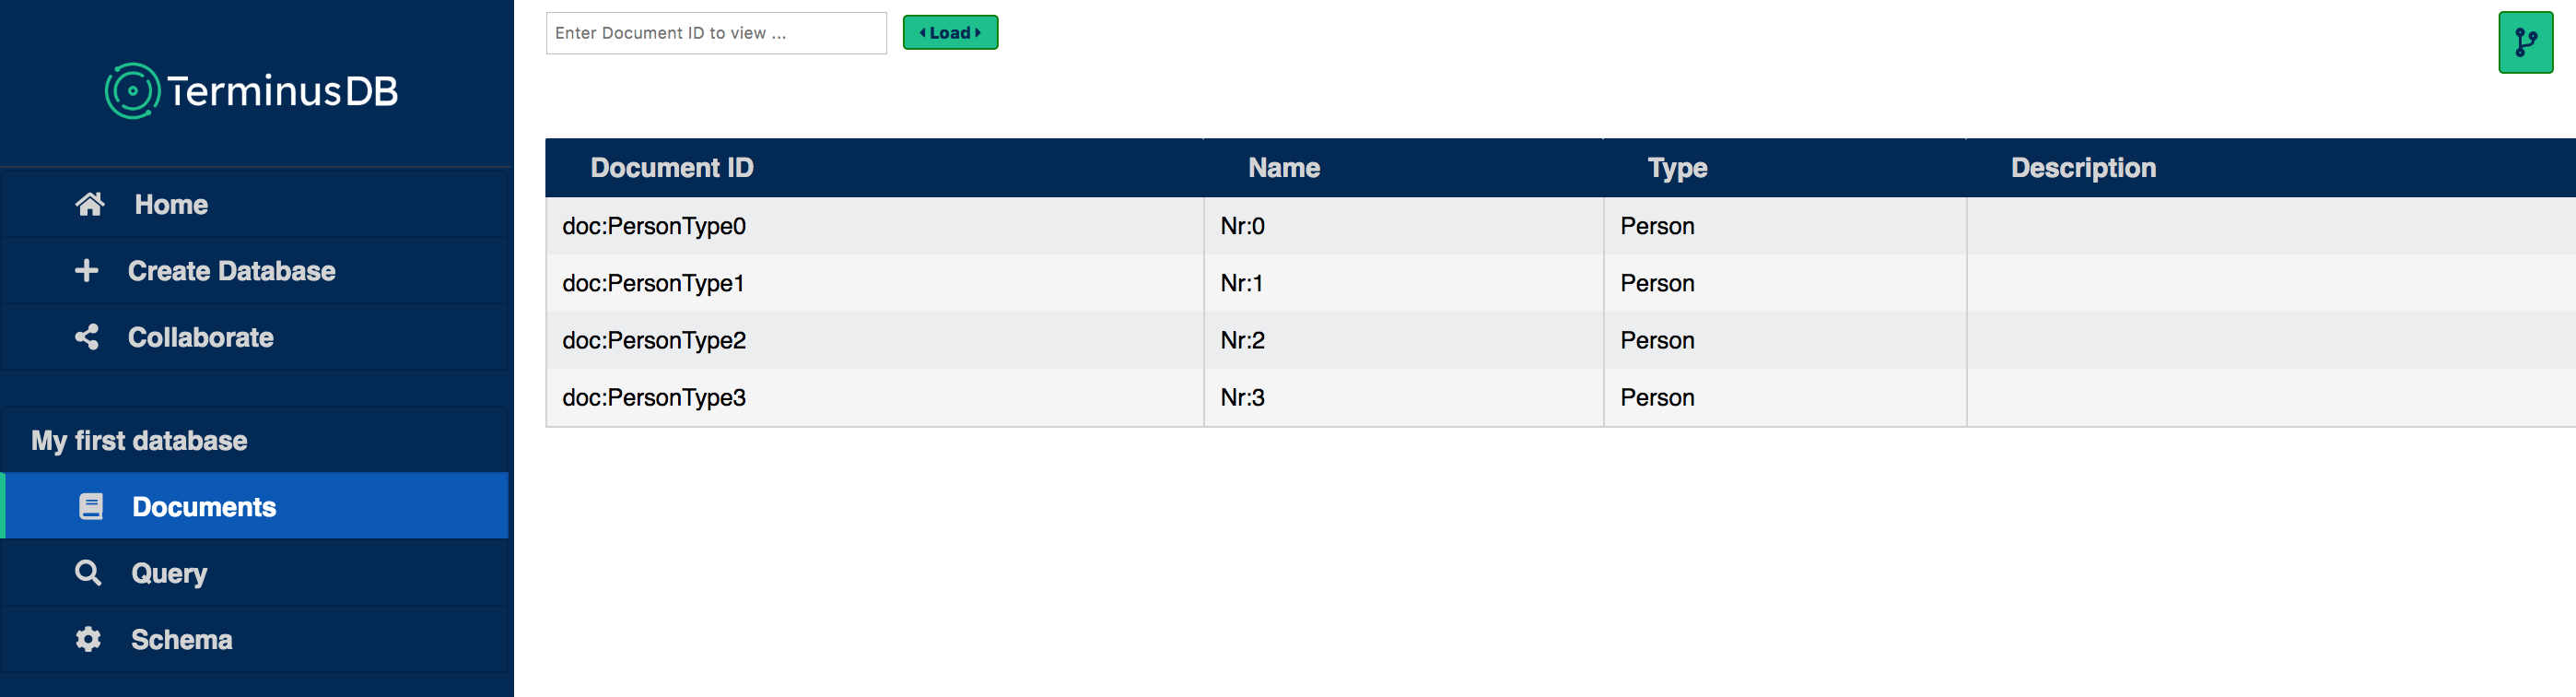

And so,  the last two documents,  numbers 4 and 5, have disappeared..

As an observation, note that `delete_triple` well, deletes a triple.  And so if we had, for example, specified a property such as `Age`,  we could have removed the age property of our selected people (those over 50) and so hidden their ages, rather than deleting entire documents: `delete_triple("v:Person", "Age", "v:Age")`.  

This in turn means that the schema does not necessarily describe every instance: some people may have ages, but others may have had their age property explicitly removed. If you then query using the age property of people,  those people which are missing that property will not be eligible as results for the query.

The TerminusDB WOQL allows us to be as fine-grained as we like:  since *everything* is a triple, you can go ahead and select the triples you want,  and then manipulate only those...

---

# To Come
Further things for which it would be good to write up a tutorial like this:
* Reading raw data from external .csv files
* Building documents with relationships between them
* Building class hierarchies..